In [66]:
import csv
import math
import sys, time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *
from tqdm.notebook import tqdm

In [67]:
def generateGraph():
    """
    La fonction permet de générer un Graph aléatoire et tous les éléments associés 
    """
    # Use seed when creating the graph for reproducibility
    G1 = nx.barabasi_albert_graph(100, 5)

    # print(nx.is_connected(G1))

    if nx.is_connected(G1)==False:
        largest_cc = max(nx.connected_components(G1), key=len)
        G = G1.subgraph(largest_cc).copy() 
    else:
        G = G1.copy()


    # position is stored as node attribute data for random_geometric_graph
    pos = nx.get_node_attributes(G, "pos")

    site = {}
    G2 = nx.Graph()

    for node in G.nodes():
        site[node] = str(node)

    for (u,v) in G.edges():
        a = u 
        b = v
        if (a>b):
            a, b = b,a
        G2.add_edge(a,b)
        G2[a][b]['capa'] = np.random.random()*0.5 + 0.5 
        G[a][b]['capa'] = np.random.random()*0.5 + 0.5 

    n_demand = 15
    K = nx.DiGraph()


    for k in range(n_demand):
        nodeA = np.random.randint(200)
        while nodeA not in G.nodes():
            nodeA = np.random.randint(200)

        nodeB = np.random.randint(200)
        while nodeA == nodeB or nodeB not in G.nodes() :
            nodeB = np.random.randint(200)
            
        if nodeA > nodeB:
            tmp = nodeA
            nodeA = nodeB
            nodeB = tmp
            
        K.add_edge(nodeA,nodeB)                    
        K[nodeA][nodeB]['demand'] = np.clip(np.random.normal(1,1), a_min=0, a_max = 2)

    H = nx.DiGraph(G2)
    capa = {}

    for (u,v) in G2.edges():
        capa[(u,v)] = G2[u][v]['capa']
        capa[(v,u)] = G2[u][v]['capa']

    return G2, K, H, pos, site, capa

# G, K, H, pos, site, capa = generateGraph()

In [68]:
def Solver(G, H, K, capa):
    """
    La fonction qui résout le max flow lié aux Graphs

    Paramètres : 
    --------
    G : le graphe des liaisons
    H : le graphe des capacités
    K : le graphe des demandes
    capa : la liste des capacités
    Returns :
    -------
    model
    """
    def flowConservation(model, node, o, d):
        inFlow = sum(
            model.flow[i, j, o, d]
            for (i, j) in model.arcs
            if j == node
        )
        outFlow = sum(
            model.flow[i, j, o, d]
            for (i, j) in model.arcs
            if i == node
        )
        if node == o:
            return (inFlow - outFlow + K[o][d]['demand'] == 0)
        elif node == d:
            return (inFlow - outFlow - K[o][d]['demand'] == 0)
        else:
            return (inFlow == outFlow)
    
    def linkCapacity(model, i, j):
        expression = sum(model.flow[i,j,o,d] + model.flow[j,i,o,d] for (o,d) in model.demands)<= model.capa[i,j] * model.gamma
        return expression

    solver = 'cplex'

    # print('>>> Loading optimization model')

    model = ConcreteModel()

    model.dual = Suffix(direction=Suffix.IMPORT)

    model.nodes = H.nodes()
    model.links = G.edges()
    model.arcs = H.edges()
    model.demands = K.edges()

    model.index1 = Set(initialize=[(u, o, d)
                       for u in model.nodes for (o, d) in model.demands])
    model.index2 = Set(initialize=[(u, v, o, d) for (
        u, v) in model.arcs for (o, d) in model.demands])

    model.capa = Param(model.arcs, initialize=capa)

    model.flow = Var(model.index2, domain=NonNegativeReals)
    model.gamma = Var(domain=NonNegativeReals)

    model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

    model.flowConserv = Constraint(model.index1, rule=flowConservation)

    model.linkCapa = Constraint(model.links, rule=linkCapacity)

    # print('>>> Solving optimization model')

    optim = SolverFactory(solver)

    start_time = time.time()

    results = optim.solve(model)

    cpu_time = time.time() - start_time

    # print('+ TERM STAT:', results.solver.status)
    # print('+ TERM COND:', results.solver.termination_condition)

    # print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

    # if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    #     print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    #     print(
    #         '+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

    return model


In [69]:
epsilon = 1.0e-06

def getLoad(model, G, K, site):
    """
    La fonction renvoie le chargement total de chaque edge

    Paramètres :
    ----------
    model
    G
    K
    site

    Returns : 
    -------
    load
    """
    load = {}

    for (u, v) in G.edges():
        TotalFlow = 0.0
        for (o, d) in K.edges():
            # On somme pour chaque lien le flow qui passe
            TotalFlow += model.flow[u, v, o, d].value
            TotalFlow += model.flow[v, u, o, d].value
        G[u][v]['flow'] = TotalFlow
        a = u
        b = v
        if a> b:
            a, b =b,a
        if TotalFlow > epsilon:
            load[(a,b)] = 100*TotalFlow/model.capa[(a,b)]
        else:
            load[(a,b)] = 0.0
    
    return load


In [70]:
def isSaturated(G, uv, model, load):
    isAttained = np.zeros(np.max(G.edges)+1)
    queue = collections.deque()
    u = uv[0]
    v = uv[1]
    isAttained[u] = 1
    for n in G.neighbors(u):
        a = u
        b = n
        if u > n :
            b = u
            a = n
        if n not in queue and abs(load[(a,b)] - model.gamma.value*100) > epsilon:
            queue.append(n)

    while isAttained[v] == 0 and len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        for n1 in G.neighbors(n):
            a = n1
            b = n
            if a > b :
                a, b =b, a
            if (n1 not in queue) and (isAttained[n1] == 0) and abs(load[(a, b)] - model.gamma.value*100) > epsilon:
                queue.append(n1)
    return isAttained[v] == 0

def getCriticalEdges(model, G, K, site, load):
    """ 
    Returns :
    -------
    criticalEdges
    """
    model.gamma.value
    load1 = {}
    G1 = G.copy()
    Saturated_edges = []

    for (u, v) in G1.edges():
        TotalFlow1 = 0.0
        for (o, d) in K.edges():
            # On somme pour chaque lien le flow qui passe
            TotalFlow1 += model.flow[u, v, o, d].value
            TotalFlow1 += model.flow[v, u, o, d].value
        G1[u][v]['flow'] = TotalFlow1
        if abs(100*TotalFlow1 / model.capa[(u, v)] - model.gamma.value*100) < epsilon:
            Saturated_edges.append((u, v))
            load1[(u, v)] = 100*TotalFlow1 / model.capa[(u, v)]


    # print(Saturated_edges)
    

    criticalEdges = []
    for uv in Saturated_edges:
        if isSaturated(G, uv, model, load):
            a = uv[0]
            b = uv[1]
            if a>b:
                a,b = b,a
            criticalEdges.append((a,b))
    # print('')
    # print('_____ Critical Edges ____')
    # for (u, v) in criticalEdges:
    #     print('link ({0:10s}, {1:10s})\t'.format(
    #         site[u], site[v]), 'site 1 = ' + str(u) + ', site 2 = ' + str(v))
    # # print([site[criticalEdges[k][0]] + ' -> ' + site[criticalEdges[k][1]] for k in range(len(criticalEdges))])

    return criticalEdges


In [71]:
def getCriticalSources(model, K, criticalEdges):
    """
    Parameters :
    ----------
    model
    K
    criticalEdges

    Returns :
    -------
    criticalDemands
    criticalNodes
    """
    criticalNodes = []
    criticalDemand = []
    # criticalDestination = []
    for (o,d) in K.edges():
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
        bool = False
        for (u,v) in model.arcs:
            a = u
            b = v
            if a>b:
                a,b = b,a
            if (a, b) in criticalEdges and model.flow[u,v,o,d].value > epsilon:
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))
                bool = True
        if (bool):
            criticalDemand.append((o,d))
            if o not in criticalNodes :
                criticalNodes.append(o)
            if d not in criticalNodes:
                criticalNodes.append(d)
    return criticalDemand, criticalNodes

In [72]:
### Clustering 
def clustering(G, critical_edge, criticalDemands):
    G1 = G.copy()
    for u,v in critical_edge:
        G1.remove_edge(u,v)


    S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

    print(len(S))


    link = nx.Graph()
    listEdgesBetween = {}
    listDemandsBetween = {}



    for u,v in critical_edge:
        a = np.infty
        b = np.infty
        for k in range(len(S)) :
            if u in S[k].nodes():
                a = k
            if v in S[k].nodes():
                b = k 
        if a > b :
            a, b = b, a
        if (a, b) not in link.edges():
            link.add_edge(a ,b)
        if ((a,b) in listEdgesBetween):
            listEdgesBetween[(a,b)].append((u,v))
        else :
            listEdgesBetween[(a,b)] = [(u,v)]

    # nx.draw(link, node_size=500, node_color='lightgrey', width=4)


    for (u,v) in criticalDemands : 
        for k in range(len(S)):

            g1 = S[k]
            if u in g1.nodes():
                for j in range(len(S)):
                    g2 = S[j]
                    if v in g2.nodes():
                        a = k
                        b = j
                        if a > b:
                            a, b = b, a
                        if (a, b) in listDemandsBetween : 
                            listDemandsBetween[(a,b)].append((u,v))
                        else :
                            listDemandsBetween[(a,b)] = [(u,v)]
                    if (a, b) not in listDemandsBetween : 
                        listDemandsBetween[(a,b)] = []
    for (u,v) in link.edges():
        a = u
        b = v 
        if a> b:
            a,b = b,a
        link[a][b]['capa'] = 0
        for (x,y) in listEdgesBetween[(a,b)]:
            link[u][v]['capa'] += G[x][y]['capa']
        # print(link[u][v]['capa'])
    
    return link, listDemandsBetween, listEdgesBetween, S


In [73]:
def computeMinCut(link, listDemandsBetween, listEdgesBetween, K, S):
    def priceCut(sameSideNodes) : 
        return nx.cut_size(link, sameSideNodes, weight='capa')

    def demandCut(sameSideNodes):
        demand = 0
        for (u,v) in listDemandsBetween :
            if (u in sameSideNodes and v not in sameSideNodes) or (v in sameSideNodes and u not in sameSideNodes):
                for a,b in listDemandsBetween[(u,v)]:
                    if (a>b):
                        a,b =b,a
                    demand += K[a][b]['demand']

        return demand

    def cut1(A, B):
        link2 = link.copy()
        link2.remove_node(B)
        tableNodesSameSides = [link2.subgraph(c).copy() for c in nx.connected_components(link2)]
        # nx.draw(link2, node_size=500, node_color='lightgrey', width=4)
        for t in tableNodesSameSides :
            if A in t.nodes():
                return t.nodes()

    def minCut2():
        cut = np.infty
        cutChoosen = None
        listEgdesChoosen = None
        for k in link.nodes():
            for j in link.neighbors(k):
                sameSideNodes = cut1(k, j)
                price = priceCut(sameSideNodes)
                demand = demandCut(sameSideNodes)
                if (demand > 0 and cut > price/demand):
                    cut = price/demand
                    cutChoosen = (k,j)
                    listEgdesChoosen = edgesChoosen(sameSideNodes)

        return cut, cutChoosen, listEgdesChoosen

    def edgesChoosen(cutChoosen):
        listEgdesChoosen = []
        for (u,v)  in listEdgesBetween:
            if (u in cutChoosen and v not in cutChoosen) or (v in cutChoosen and u not in cutChoosen) :
                for a,b in listEdgesBetween[(u,v)] : 
                    listEgdesChoosen.append((a,b))
        return listEgdesChoosen



    mincut, cutChoosen, listEgdesChoosen = minCut2()

    # print('_____ Critical Choosen Edges _____')
    criticalChoosenEdges = listEgdesChoosen # We consider the first solution
    # for (u,v) in criticalChoosenEdges:
        # print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v), ', capa = ', G[u][v]['capa'])
    # print(criticalChoosenEdges)


    # print(sameSideNodes)
    print('mincut = ', mincut)
    # print('maxflow = ', 1/model.gamma.value)


    return mincut, listEgdesChoosen, cutChoosen


In [74]:
def minCut(): 
    G, K, H, pos, site, capa = generateGraph()
    model = Solver(G, H, K, capa)
    load = getLoad(model, G, K, site)
    criticalEdges = getCriticalEdges(model, G, K, site, load)
    criticalDemands, criticalNodes = getCriticalSources(model, K, criticalEdges)
    link, listDemandsBetween, listEdgesBetween, S  = clustering(G, criticalEdges, criticalDemands)
    min,listEgdesChoosen, cutChoosen = computeMinCut(link, listDemandsBetween, listEdgesBetween, K, S)
    return min, model.gamma.value, G, K, H, pos, site, capa,  listEgdesChoosen, criticalEdges, load, link, cutChoosen
    

In [75]:
def printGraph(gamma, G, criticalChoosenEdges, criticalEdges, load, site, pos, K):
    plt.figure(figsize=(30,30));
    plt.axis('off')

    colors = []
    for (a,b) in G.edges():
        u = a
        v = b
        if u>v:
            u,v = v,u
        if (u,v) in criticalChoosenEdges :
            colors.append('blue')
        # elif load[(u,v)] > 100:
        #     colors.append('black')
        elif (u,v) in criticalEdges:
            colors.append('black')
        elif load[(u,v)] > gamma *100 - epsilon:
            colors.append('red')
        elif load[(u,v)] > 50:
            colors.append('orange')
        elif load[(u,v)] >=25:
            colors.append('green')
        elif load[(u,v)] >=0:
            colors.append('lightgreen')
        else:
            colors.append('lightgrey')


    fig = plt.figure(1, figsize=(200, 80), dpi=500)
    nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')

    nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color=colors, width=4)
    nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')


  0%|          | 0/100 [00:00<?, ?it/s]

2
mincut =  1.2792811785663651
1.2792811785663651
3
mincut =  1.9698607093159624
1.9698607093159626
2
mincut =  1.964630196621529
1.9646301966215292
3
mincut =  1.2420510440670107
1.2420510440670107
2
mincut =  1.0520491073293148
1.0520491073293148
3
mincut =  1.839489978922554
1.839489978922554
2
mincut =  1.8069528774616053
1.8069528774616053
3
mincut =  1.433306793617414
1.433306793617414
3
mincut =  1.1212797076474066
1.1212797076474066
2
mincut =  1.288132267285371
1.288132267285371
3
mincut =  2.022714341564896
2.0227143415648956
3
mincut =  2.1012914063140427
2.101291406314042
5
mincut =  1.7798110576041937
1.7798110576041937
4
mincut =  1.5620904929643036
1.5620904929643034
4
mincut =  1.9666554630812971
1.9666554630812971
4
mincut =  1.7502690181566627
1.7502690181566627
2
mincut =  1.7900223580422943
1.7900223580422938
4
mincut =  2.2096319425412334
2.2096319425412334
7
mincut =  1.8029725549273925
1.802972554927392
2
mincut =  1.9526544509563188
1.9526544509563188
3
mincut =

KeyError: 0

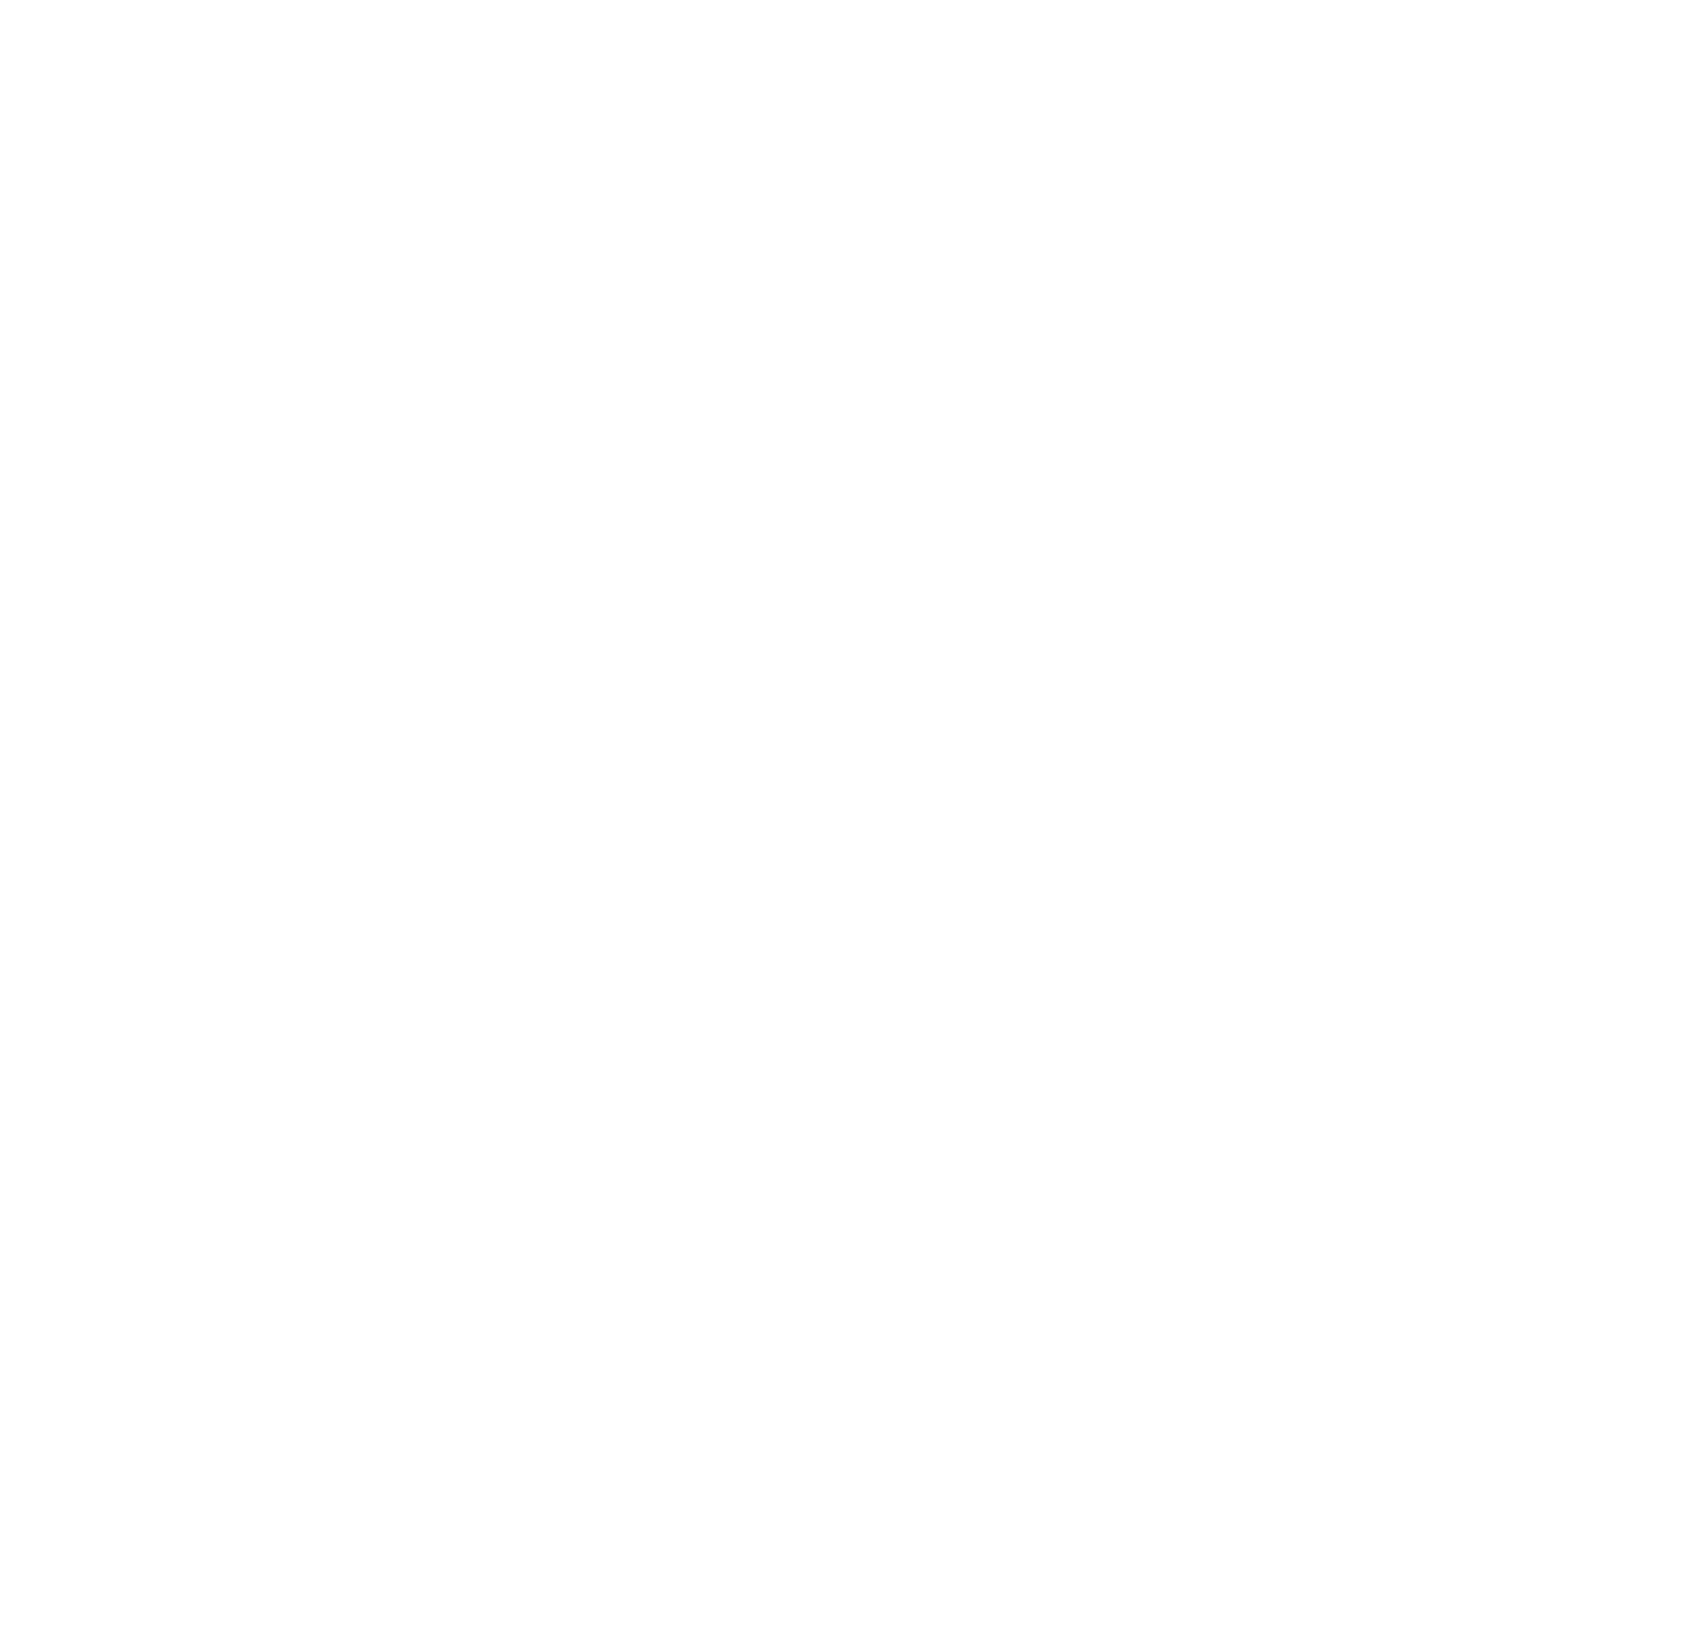

In [76]:
minCuts = []
maxFlows = []

bool = False
for k in tqdm(range(100), total=100):
    min, gamma, G, K, H, pos, site, capa, criticalChoosenEdges, criticalEdges, load, link, cutChoosen = minCut()
    if gamma !=0:
        print(1/gamma)
        if not bool and np.abs(1/gamma - min ) > epsilon  and min < np.infty:
            # print(criticalChoosenEdges)
            printGraph(gamma, G, criticalChoosenEdges, criticalEdges, load, site, pos, K)
            # nx.draw_networkx(link)
            bool = True
            # nx.draw_networkx(link)
            # graphCut = link.copy()
            # pos2 = nx.get_node_attributes(link, "pos")
            break

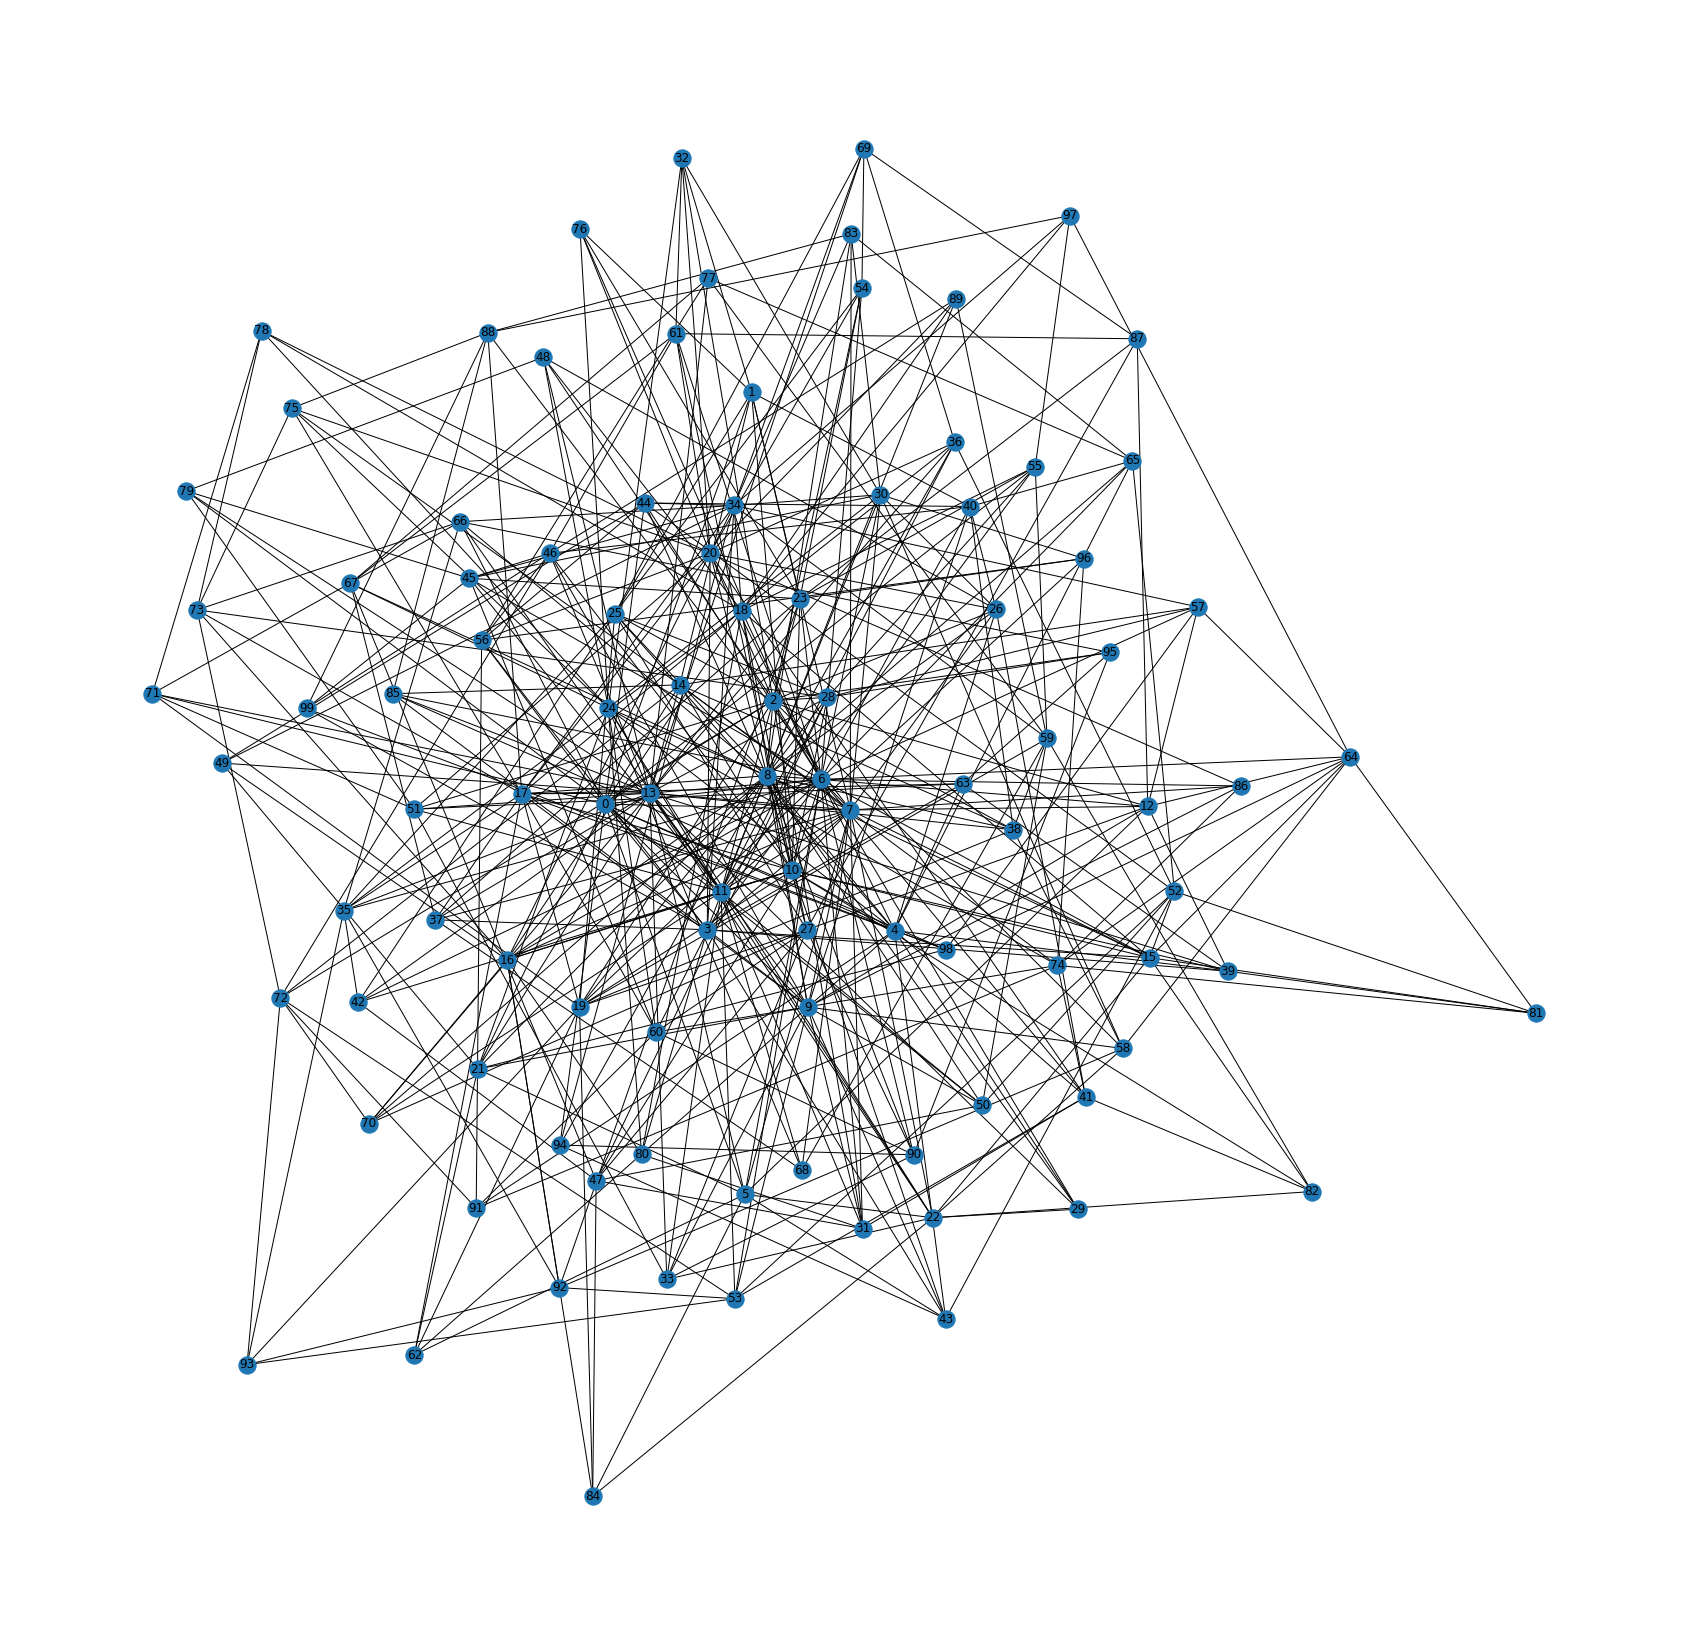

In [78]:
plt.figure(figsize=(30,30));
plt.axis('off')


nx.draw_networkx(G)

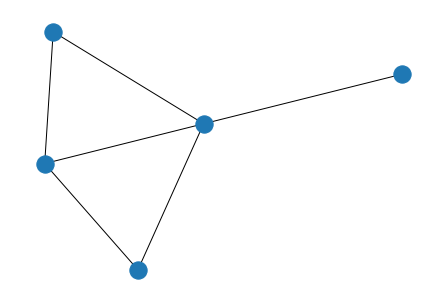

In [79]:
nx.draw(link)